In [66]:
from pycorenlp import StanfordCoreNLP
from nltk.tree import *

nlp = StanfordCoreNLP('http://localhost:9000')

text = 'Although specific drug interaction studies have not been conducted with ALPHAGAN P, the possibility of an additive or potentiating effect with CNS depressants (alcohol, barbiturates, opiates, sedatives, or anesthetics) should be considered.'


dict_keys(['index', 'parse', 'basicDependencies', 'enhancedDependencies', 'enhancedPlusPlusDependencies', 'tokens'])


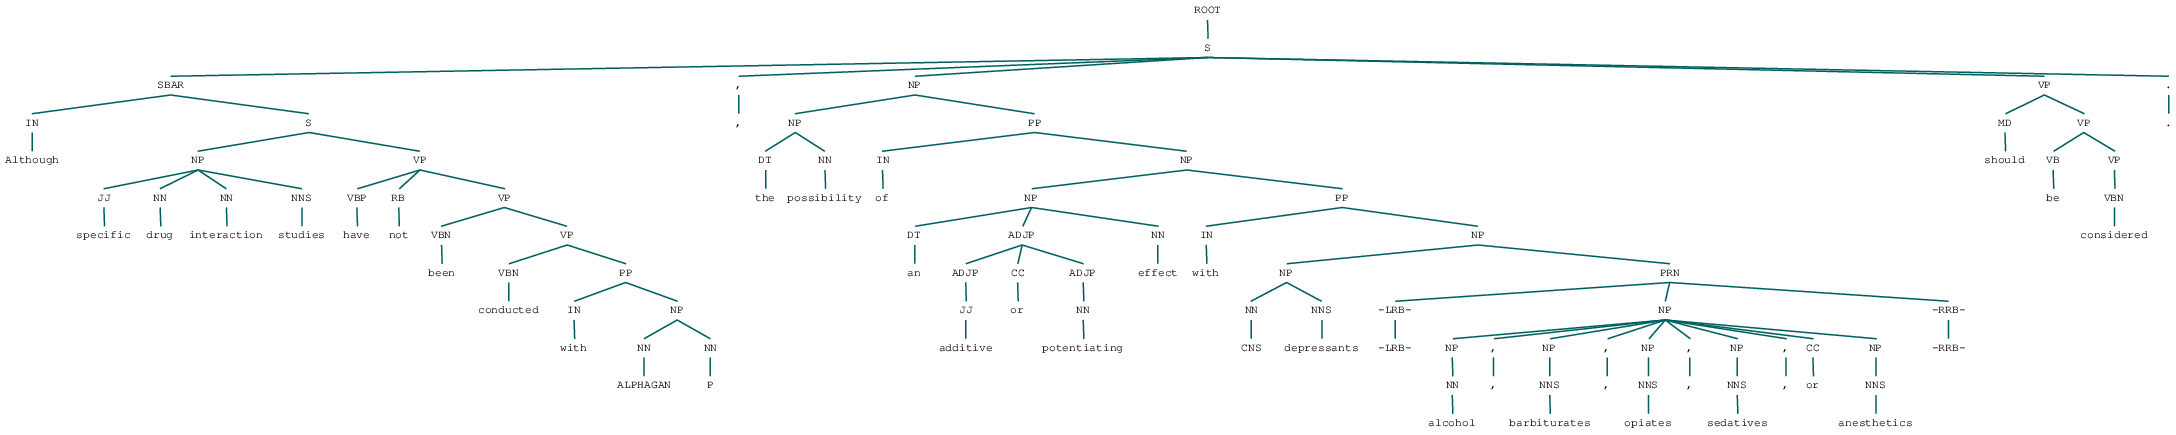

In [68]:

output = nlp.annotate(text, properties={
  'annotators': 'parse',
  'outputFormat': 'json'
})
for s in output['sentences']:
    print(s.keys()) # tagged output sentence
    
s = output['sentences'][0]


# print(s['parse'])

tree_parsed = Tree.fromstring(s['parse'])
tree_parsed

In [100]:
from nltk.stem import WordNetLemmatizer
from nltk.tag import PerceptronTagger
from nltk.corpus import wordnet as wn
def penn_to_wn(tag):
    if tag in ['JJ', 'JJR', 'JJS']:
        return wn.ADJ
    elif tag in ['NN', 'NNS', 'NNP', 'NNPS']:
        return wn.NOUN
    elif tag in ['RB', 'RBR', 'RBS']:
        return wn.ADV
    elif tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']:
        return wn.VERB
    return wn.NOUN

def preprocessor_lemmatize(tagged):
    lemmatizer = WordNetLemmatizer()
    result = []
    for word, tag in tagged:
        # A verb for sure if it ends in ing (?).
        # Sometimes, verbs are wrongly classified, for example, "A man is smoking" (Smoking => Noun)
        lemma = wordtext
        if not 'NN' in tag:
            if word.endswith('ing'):
                tag = 'VB'
            lemma = lemmatizer.lemmatize(word, penn_to_wn(tag))
        result.append((lemma, tag))
    return result

In [128]:
import re
w = 'w,'
re.sub(r'[^\w]', '', w)

'w'

In [134]:
to_remove = ['-LRB-','-RRB-',',','.','a','A']

def clean_sentence(sentence_splitted):
    clean = []
    for w in sentence_splitted:
        if w not in to_remove:
            w = re.sub(r'([^a-zA-Z\s]+?)', '', w)
            if w:
                clean.append(w)
    return clean

def all_drugs_in_tree(target_drugs, leafs):
    for drug in target_drugs:
        if re.sub(r'[^\w]', '', drug) not in leafs:
            return False
    return True

def smaller_subtree_containing_the_drugs(sentence, target_drugs):
    tree_string = nlp.annotate(sentence, properties={'annotators': 'parse', 'outputFormat': 'json'})
    if len(tree_string['sentences']) >1:
        print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!',len(tree_string['sentences']))
    i = 0
    tagger = PerceptronTagger()
    best_subtree = None
    size = 9999999
    target_drugs = [dr for drug in target_drugs for dr in drug.split(' ')]
    for s in tree_string['sentences']:
        tree_parsed = Tree.fromstring(s['parse'])
        for subtree in tree_parsed.subtrees():
            #         print(subtree.pretty_print())
            leafs = subtree.leaves()
            current_size = len(leafs)
            if all_drugs_in_tree(target_drugs, leafs):
                if current_size < size:
                    best_subtree = subtree
                    size = current_size
        #                 print(subtree.leaves())

    try:
        clean = clean_sentence(best_subtree.leaves())
    except:
        clean = clean_sentence(sentence.split())
    print('clean',clean)
    tagged = tagger.tag(clean)
    print('tag:', tagged)
    lemmatized = preprocessor_lemmatize(tagged)
    print('lemmatized', lemmatized)
    new_sentence = ' '.join([l for l, t in lemmatized])


    return new_sentence


s = 'Antacids: In a single dose study (n=6), ingestion of an antacid containing 1.7-gram of magnesium hydroxide with 500-mg of mefenamic acid increased the Cmax and AUC of mefenamic acid by 125% and 36%, respectively.  A number of compounds are inhibitors of CYP2C9 including fluconazole, lovastatin and trimethoprim.'

e1 = 'Antacids'
e2  =  'fluconazole'
my_cute_tree = smaller_subtree_containing_the_drugs(s,[e1,e2])

my_cute_tree

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 2
clean ['Antacids', 'In', 'single', 'dose', 'study', 'n', 'ingestion', 'of', 'an', 'antacid', 'containing', 'gram', 'of', 'magnesium', 'hydroxide', 'with', 'mg', 'of', 'mefenamic', 'acid', 'increased', 'the', 'Cmax', 'and', 'AUC', 'of', 'mefenamic', 'acid', 'by', 'and', 'respectively', 'number', 'of', 'compounds', 'are', 'inhibitors', 'of', 'CYPC', 'including', 'fluconazole', 'lovastatin', 'and', 'trimethoprim']
tag: [('Antacids', 'NNS'), ('In', 'IN'), ('single', 'JJ'), ('dose', 'NN'), ('study', 'NN'), ('n', 'JJ'), ('ingestion', 'NN'), ('of', 'IN'), ('an', 'DT'), ('antacid', 'NN'), ('containing', 'VBG'), ('gram', 'NN'), ('of', 'IN'), ('magnesium', 'NN'), ('hydroxide', 'NN'), ('with', 'IN'), ('mg', 'NN'), ('of', 'IN'), ('mefenamic', 'JJ'), ('acid', 'NN'), ('increased', 'VBD'), ('the', 'DT'), ('Cmax', 'NNP'), ('and', 'CC'), ('AUC', 'NNP'), ('of', 'IN'), ('mefenamic', 'JJ'), ('acid', 'NN'), ('by', 'IN'), ('and', 'CC'), ('respectively', 'RB'), ('number', '

'Antacids In single dose study n ingestion of an antacid contain gram of magnesium hydroxide with mg of mefenamic acid increase the Cmax and AUC of mefenamic acid by and respectively number of compounds be inhibitors of CYPC include fluconazole lovastatin and trimethoprim'

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 2
['Antacids:', 'In', 'a', 'single', 'dose', 'study', '(n=6),', 'ingestion', 'of', 'an', 'antacid', 'containing', '1.7-gram', 'of', 'magnesium', 'hydroxide', 'with', '500-mg', 'of', 'mefenamic', 'acid', 'increased', 'the', 'Cmax', 'and', 'AUC', 'of', 'mefenamic', 'acid', 'by', '125%', 'and', '36%,', 'respectively.', '', 'A', 'number', 'of', 'compounds', 'are', 'inhibitors', 'of', 'CYP2C9', 'including', 'fluconazole,', 'lovastatin', 'and', 'trimethoprim.']


IndexError: string index out of range

In [75]:
' '.join([w for w in my_cute_tree.leaves() if not w in to_remove])

'CNS depressants alcohol barbiturates opiates sedatives or anesthetics'

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 2


NameError: name 'all_drugs_in_tree' is not defined

In [38]:
for subtree in tree_parsed.subtrees(filter=lambda t: t.label().endswith("=H"))

nltk.tree.Tree

In [10]:

properties={
  'annotators': 'ssplit',
  'outputFormat': 'json'
  }

def sentence_split(text, properties={'annotators': 'ssplit', 'outputFormat': 'json'}):
    """Split sentence using Stanford NLP"""
    annotated = nlp.annotate(text, properties)
    sentence_split = list()
    for sentence in annotated['sentences']:
        s = [t['word'] for t in sentence['tokens']]
        sentence_split.append(s)
    return sentence_split

sentence_split(text, properties)

[['Although',
  'specific',
  'drug',
  'interaction',
  'studies',
  'have',
  'not',
  'been',
  'conducted',
  'with',
  'ALPHAGAN',
  'P',
  ',',
  'the',
  'possibility',
  'of',
  'an',
  'additive',
  'or',
  'potentiating',
  'effect',
  'with',
  'CNS',
  'depressants',
  '-LRB-',
  'alcohol',
  ',',
  'barbiturates',
  ',',
  'opiates',
  ',',
  'sedatives',
  ',',
  'or',
  'anesthetics',
  '-RRB-',
  'should',
  'be',
  'considered',
  '.']]